In [1]:
# this code is used to solve 2D shallow water QG equations
# D/Dt(\nabla^2psi+beta*y-f^2F*psi)=0 in dimensionless form
# rewritten as D/Dt(\nabla^2psi-f^2F*psi)+beta*v=0
# periodic boundary conditions in x and y
# domain: 0<=x<Lx, -Ly<=y<=Ly

In [2]:
import numpy                as np
import matplotlib
import matplotlib.pyplot    as plt 
import matplotlib.animation as animation 

In [3]:
def Get_truncate(var_fft):
    var_fftT                     = var_fft.copy()
    nfreqx                       = int(np.floor(2/3*(nx/2-1))) # nx is even, 2/3 rule
    var_fftT[:,nfreqx+1:-nfreqx] = 0
    nfreqy                       = int(np.floor(2/3*(ny/2-1))) # ny is even, 2/3 rule
    var_fftT[nfreqy+1:-nfreqy,:] = 0
    return var_fftT

def Get_RHS(PV_fft):
    # infer other variables
    ps_fft  =  PV_fft/ps2PV
    UU_fft  = -ddy*ps_fft
    VV_fft  =  ddx*ps_fft

    # 2/3 rule truncation
    PV_fftT = Get_truncate(PV_fft)
    UU_fftT = Get_truncate(UU_fft)
    VV_fftT = Get_truncate(VV_fft)
    PV_T    = np.fft.ifft2(PV_fftT).real
    UU_T    = np.fft.ifft2(UU_fftT).real
    VV_T    = np.fft.ifft2(VV_fftT).real

    # calculate nonlinear terms
    UUPV     = UU_T*PV_T
    UUPV_fft = np.fft.fft2(UUPV)
    VVPV     = VV_T*PV_T
    VVPV_fft = np.fft.fft2(VVPV)

    # hyperviscosity to remove small-scale turbulence
    coe      = 1e-9
    hyper    = -coe*lap**2*PV_fft

    # calculate RHS terms
    RHS      = -(ddx*UUPV_fft+ddy*VVPV_fft+beta*VV_fft) + hyper
    return RHS

In [4]:
# set dimensionless value of all parameters
beta = 1  # dimensionless value
f0   = 1  # dimensionless value
F    = 1  # (L/Ld)^2

# grid spacing and time stepping
Lx = 10
nx = 1000
dx = Lx/nx
xg = np.linspace(0,Lx,nx,endpoint=False)

Ly = 2
ny = 400
dy = 2*Ly/ny
yg = np.linspace(-Ly,Ly,ny,endpoint=False)

T  = 50
nt = 10000
dt = T/nt
tg   = np.linspace(0,T,nt+1,endpoint=True)
ngap = 10
tgap = tg[::ngap]

# constant coefficient matrix
lap    = np.tile(((2*np.pi*1j*np.fft.fftfreq(ny)/dy)**2).reshape((-1, 1)),[ 1,nx]) + \
         np.tile(((2*np.pi*1j*np.fft.fftfreq(nx)/dx)**2).reshape(( 1,-1)),[ny, 1])
ddx    = np.tile((2*np.pi*1j*np.fft.fftfreq(nx)/dx).reshape((1,-1)),[ny,1])
ddy    = np.tile((2*np.pi*1j*np.fft.fftfreq(ny)/dy).reshape((-1,1)),[1,nx])
ps2PV  = lap - f0**2*F


In [5]:
# initialize variable
ps_save = np.zeros((int(nt/ngap)+1,ny,nx))
PV_save = np.zeros((int(nt/ngap)+1,ny,nx))
UU_save = np.zeros((int(nt/ngap)+1,ny,nx))
VV_save = np.zeros((int(nt/ngap)+1,ny,nx))

# initialize variable (physics space)
vp     = (np.exp(-16*yg**2)).reshape((-1,1))*  \
         (np.exp(-16*(xg-Lx/2)**2)).reshape((1,-1))
PV     = np.zeros((ny,nx))
for i in np.arange(20):
    nxsht = np.random.randint(nx)
    nysht = np.random.randint(ny)
    vpamp = 2*np.random.randint(2)-1
    print(nxsht,nysht,vpamp)
    vp1   = np.roll( vp,nxsht,axis=1)
    vp2   = np.roll(vp1,nysht,axis=0)
    PV    = PV + vpamp*vp2
PV_fft = np.fft.fft2(PV)
# fig, ax = plt.subplots(1,1,figsize=(30,12)) 
# plt.pcolor(PV,vmin=-1,vmax=1)
# plt.colorbar()

# infer all variables
ps_fft         =  PV_fft/ps2PV
UU_fft         = -ddy*ps_fft
VV_fft         =  ddx*ps_fft
PV_save[0,:,:] = np.fft.ifft2(PV_fft).real
ps_save[0,:,:] = np.fft.ifft2(ps_fft).real
UU_save[0,:,:] = np.fft.ifft2(UU_fft).real
VV_save[0,:,:] = np.fft.ifft2(VV_fft).real

for i in np.arange(1,nt+1): 
    # Use fourth-order Runge-Kutta scheme for time stepping
    q1      = dt*Get_RHS(PV_fft)
    q2      = dt*Get_RHS(PV_fft + q1/2)
    q3      = dt*Get_RHS(PV_fft + q2/2)
    q4      = dt*Get_RHS(PV_fft + q3)

    # Update PV
    PV_fft  = PV_fft + (q1 + 2*q2 + 2*q3 + q4)/6
    
    # infer all variables
    ps_fft  =  PV_fft/ps2PV
    UU_fft  = -ddy*ps_fft
    VV_fft  =  ddx*ps_fft

    # save variables
    if i%ngap==0:
        print('Saving variables at step ',i,'...')
        PV_save[int(i/ngap),:,:] = np.fft.ifft2(PV_fft).real
        ps_save[int(i/ngap),:,:] = np.fft.ifft2(ps_fft).real
        UU_save[int(i/ngap),:,:] = np.fft.ifft2(UU_fft).real
        VV_save[int(i/ngap),:,:] = np.fft.ifft2(VV_fft).real
    
print('Job finished!')

np.savez('solve_2D_nonlinear_case2.npz',PV_save=PV_save,ps_save=ps_save,UU_save=UU_save,VV_save=VV_save,   \
        xg=xg,yg=yg,tgap=tgap)


In [6]:
# npzfile = np.load('solve_2D_nonlinear_case2.npz')
# PV_save = npzfile['PV_save'][:]
# ps_save = npzfile['ps_save'][:]
# UU_save = npzfile['UU_save'][:]
# VV_save = npzfile['VV_save'][:]
# xg      = npzfile[     'xg'][:]
# yg      = npzfile[     'yg'][:]
# tgap    = npzfile[   'tgap'][:]

# print(np.amax(PV_save),np.amin(PV_save))

1.1845673027307333 -1.3983576269745863


Finish frame  0
Finish frame  0
Finish frame  1
Finish frame  2
Finish frame  3
Finish frame  4
Finish frame  5
Finish frame  6
Finish frame  7
Finish frame  8
Finish frame  9
Finish frame  10
Finish frame  11
Finish frame  12
Finish frame  13
Finish frame  14
Finish frame  15
Finish frame  16
Finish frame  17
Finish frame  18
Finish frame  19
Finish frame  20
Finish frame  21
Finish frame  22
Finish frame  23
Finish frame  24
Finish frame  25
Finish frame  26
Finish frame  27
Finish frame  28
Finish frame  29
Finish frame  30
Finish frame  31
Finish frame  32
Finish frame  33
Finish frame  34
Finish frame  35
Finish frame  36
Finish frame  37
Finish frame  38
Finish frame  39
Finish frame  40
Finish frame  41
Finish frame  42
Finish frame  43
Finish frame  44
Finish frame  45
Finish frame  46
Finish frame  47
Finish frame  48
Finish frame  49
Finish frame  50
Finish frame  51
Finish frame  52
Finish frame  53
Finish frame  54
Finish frame  55
Finish frame  56
Finish frame  57
Finish f

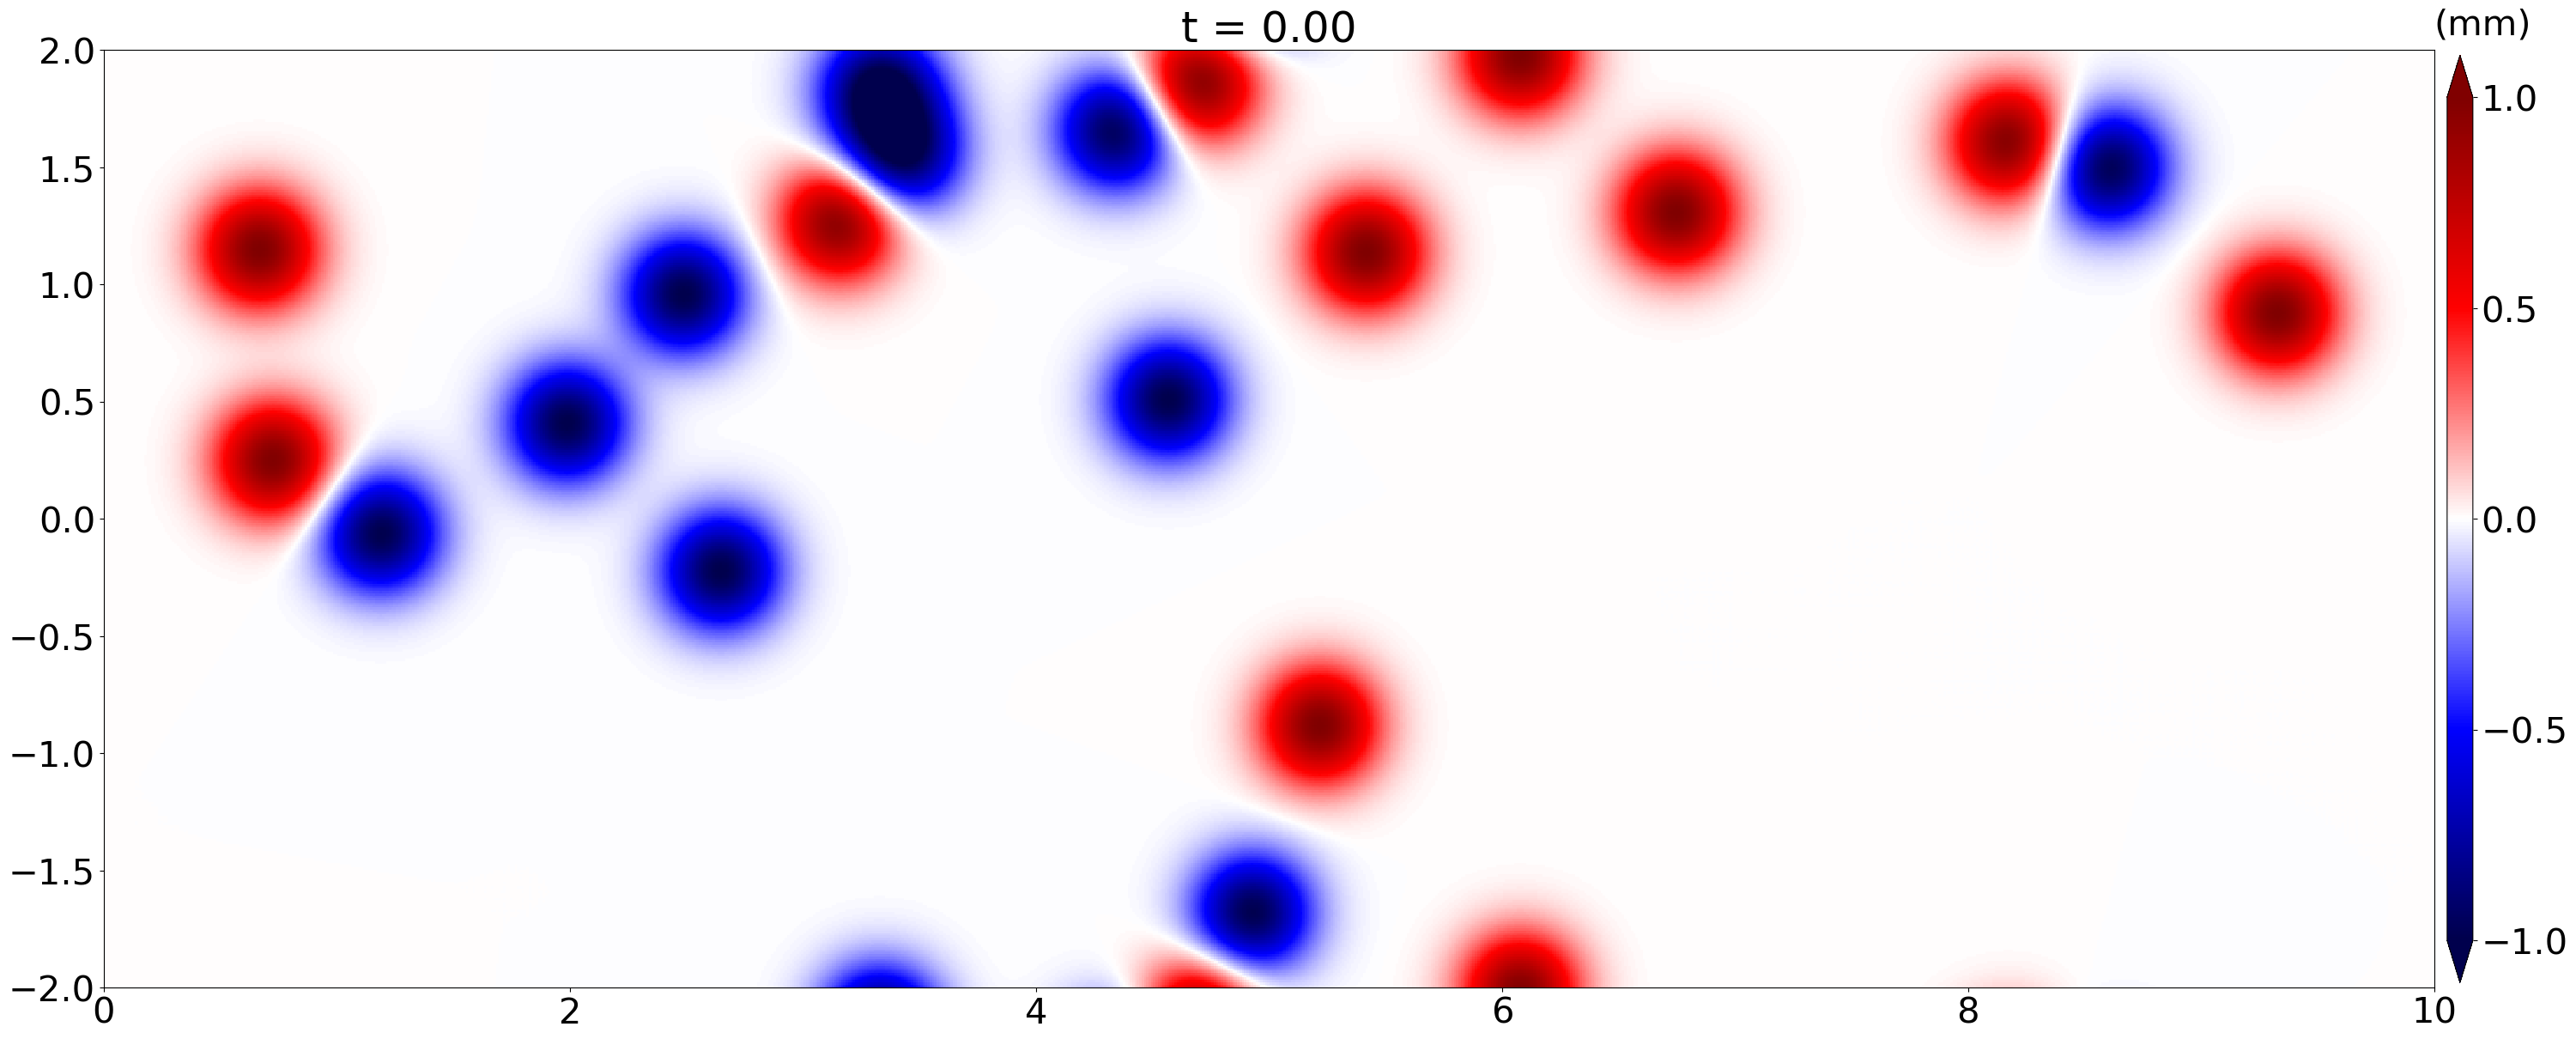

In [7]:
# plt.rcParams['font.size'] = '30'
# fig, ax = plt.subplots(1,1,figsize=(30,12)) 
# plt.subplots_adjust(left=0.040,bottom=0.040,right=0.945,top=0.950,wspace=0.06,hspace=0.07)

# nxcg = 20
# nycg = 20

# it = 0
# im = ax.pcolor(xg,yg,PV_save[it,:,:],cmap='seismic',vmin=-1,vmax=1)
# # qv = ax.streamplot(xg[::nxcg],yg[::nycg],UU_save[it,::nxcg,::nycg],VV_save[it,::nxcg,::nycg],color='k',density=2,arrowsize=3,broken_streamlines=True,arrowstyle='->')
# tt = ax.set_title(f't = {tgap[it]:.2f}')
# ax.set_xlim([  0,Lx])
# ax.set_ylim([-Ly,Ly])

# cax = fig.add_axes([0.950, 0.045, 0.010, 0.900])
# cbar = fig.colorbar(im,orientation='vertical',pad=0.01,cax=cax,extend='both')
# cbar.set_ticks(np.linspace(-1,1,5))
# plt.gcf().text(0.945, 0.965, r'(mm)', fontsize=30)

# def update(frame):
#     # global qv
#     # qv.lines.remove()
#     # for art in ax.get_children():
#     #     if not isinstance(art, matplotlib.patches.FancyArrowPatch):
#     #         continue
#     #     art.remove()        # Method 1
#     #     # art.set_alpha(0)  # Method 2
#     im.set_array(PV_save[frame,:,:].ravel())
#     tt.set_text(f't = {tgap[frame]:.2f}')
#     # qv = ax.streamplot(xg[::nxcg],yg[::nycg],UU_save[frame,::nxcg,::nycg],VV_save[frame,::nxcg,::nycg],color='k',density=2,arrowsize=3,broken_streamlines=True,arrowstyle='->')
#     print('Finish frame ',frame)

# anim = animation.FuncAnimation(fig, update, frames=1001,repeat=True)
# writervideo = animation.FFMpegWriter(fps=10) 
# anim.save('solve_2D_nonlinear_case2.mp4', writer=writervideo) 